# Final Project: Clean Label Poison Attack On Traffic Sign Dataset (Frozen Model)

# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing PyTorch and Packages


In [2]:
import os
from os import listdir
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
from torchvision.models import resnet34, ResNet34_Weights
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, ToPILImage
from torchvision.transforms import v2
from google.colab.patches import cv2_imshow

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from collections import Counter

from prettytable import PrettyTable
import operator
import os.path

# this debugs plt.imshow
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# set seeds

np.random.seed(11)
random.seed(11)
torch.manual_seed(11)
torch.cuda.manual_seed(11)

# Loading Data

In [4]:
# Load traffic sign dataset from Google Drive
# Source: https://www.kaggle.com/andrewmvd/road-sign-detection

# Parse XML files
img_path = Path('/content/drive/MyDrive/roadsigns/images')
anno_base_path = Path('/content/drive/MyDrive/roadsigns/annotations')
class_dict = {'trafficlight': 0, 'crosswalk': 1, 'speedlimit': 2, 'stop': 3}

def get_files(root, file_type):
  return [os.path.join(directory_path, f) for directory_path, directory_name,
            files in os.walk(root) for f in files if f.endswith(file_type)]

# Create Pandas Dataframe With Filename, Height, Width, Class, and Bounding Boxes
def make_train_df(anno_base_path):
  annotations = get_files(anno_base_path, '.xml')
  anno_list = []
  for anno_path in annotations:
    root = ET.parse(anno_path).getroot()
    for obj in root.findall('object'):
      anno = {}
      anno['filename'] = Path(str(img_path) + '/' + root.find("./filename").text)
      anno['width'] = root.find("./size/width").text
      anno['height'] = root.find("./size/height").text
      classname = obj.find("./name").text
      anno['class'] = class_dict[str(classname)]
      anno['xmin'] = int(obj.find("./bndbox/xmin").text)
      anno['ymin'] = int(obj.find("./bndbox/ymin").text)
      anno['xmax'] = int(obj.find("./bndbox/xmax").text)
      anno['ymax'] = int(obj.find("./bndbox/ymax").text)
      anno_list.append(anno)
  return pd.DataFrame(anno_list)

# Create training dataframe
df_train = make_train_df(anno_base_path)

# Analyze Dataset - dataset is heavily skewed towards speedlimit signs
print(df_train.shape)
print(df_train.head())
print(df_train.describe())
print(df_train['class'].value_counts())

(1244, 8)
                                            filename width height  class  \
0  /content/drive/MyDrive/roadsigns/images/road10...   400    200      2   
1  /content/drive/MyDrive/roadsigns/images/road11...   400    247      2   
2  /content/drive/MyDrive/roadsigns/images/road12...   400    283      2   
3  /content/drive/MyDrive/roadsigns/images/road10...   400    364      2   
4  /content/drive/MyDrive/roadsigns/images/road11...   400    274      2   

   xmin  ymin  xmax  ymax  
0   195     7   392   194  
1   254    32   319   102  
2    79    20   230   229  
3    48    14   344   345  
4   171    38   307   186  
             class         xmin         ymin         xmax         ymax
count  1244.000000  1244.000000  1244.000000  1244.000000  1244.000000
mean      1.639068   120.271704   165.429260   173.812701   225.758039
std       0.806720    54.799893    74.359084    63.751096    66.051956
min       0.000000     0.000000     0.000000     7.000000    31.000000
25%       

In [5]:
# get list of class images

#sign_class = 1
#sign_class = df_train[df_train['class'] == sign_class]
#sign_class = sign_class['filename'].apply(os.path.basename)
#pd.set_option("display.max_rows", None, "display.max_columns", None)
#print(sign_class)

In [6]:
pd.set_option('display.max_colwidth', None)
#print(x_test['new_path'])
#print(x['new_path'])
#print(df_train)#

# Resize Images and Process Bounding Boxes

In [7]:
# Transformation Functions

def read_image(path):
    # read image
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, img):
    # Create mask for the bounding box of same shape as image
    rows,cols,*_ = img.shape
    mask = np.zeros((rows, cols))
    bb = bb.astype(int)
    mask[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return mask

def mask_to_bb(mask):
    # Convert mask to a bounding box, assumes 0 as background nonzero object
    cols, rows = np.nonzero(mask)
    if len(cols)==0:
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(img):
    # Generates bounding box array from a df_train row
    return np.array([img[5],img[4],img[7],img[6]])

def resize_img_bb(r_path, w_path, bb, size):
    # Resize image and bounding box and write image to new path
    img = read_image(r_path)
    img_resized = cv2.resize(img, (int(1.49*size), size))
    im_resized = cv2.resize(create_mask(bb, img), (int(1.49*size), size))
    new_path = f'{w_path}/{r_path.parts[-1]}'
    cv2.imwrite(new_path, cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))
    print(f'saved resized img to {new_path}')
    return new_path, mask_to_bb(im_resized)

def resize_img_bb_and_save(r_path, w_path, bb, size):
    # Resize image and bounding box and write image to new path
    img = read_image(r_path)
    img_resized = cv2.resize(img, (int(1.49*size), size))
    im_resized = cv2.resize(create_mask(bb, img), (int(1.49*size), size))
    new_path = f'{w_path}/{r_path.parts[-1]}'
    cv2.imwrite(new_path, cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))
    print(f'saved resized img to {new_path}')
    new_bb_path = f'{w_path}/{r_path.parts[-1]}.bb.npy'
    bb_resized = mask_to_bb(im_resized)
    np.save(new_bb_path, bb_resized)
    print(f'saved resized bounding box to {new_bb_path}')
    return new_path, bb_resized

def load_or_resize_img_bb(r_path, w_path, bb, size):
    new_path = f'{w_path}/{r_path.parts[-1]}'
    new_bb_path = f'{w_path}/{r_path.parts[-1]}.bb.npy'
    if os.path.isfile(new_path) and os.path.isfile(new_bb_path):
      bb_resized = np.load(new_bb_path)
      return new_path, bb_resized
    return resize_img_bb_and_save(r_path, w_path, bb, size)

#Check Images and Bounding Boxes

In [8]:
# Sample image
idx = 58
img = cv2.imread(str(df_train.values[idx][0]))
bb = create_bb_array(df_train.values[idx])
print(img.shape)

# Check mask function
mask = create_mask(bb, img)
mask_to_bb(mask)

(225, 400, 3)


array([ 74., 147., 162., 243.], dtype=float32)

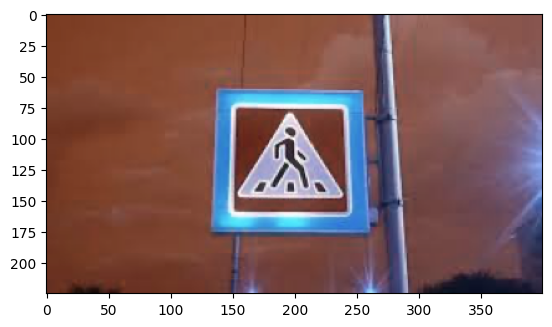

In [9]:
# Images load as BGR
plt.imshow(img)

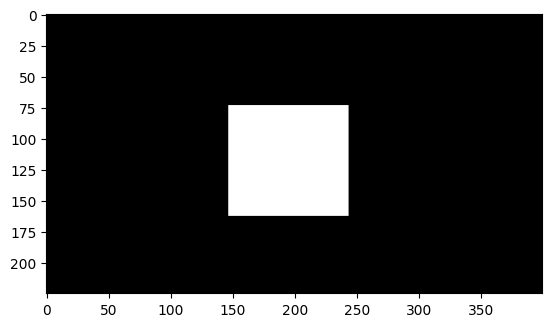

In [10]:
# Show mask
plt.imshow(mask, cmap='gray')

#Resize Images and Bounding Boxes

In [11]:
# Functions to show bounding box

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=1)

def show_corner_bb(img, bb):
    plt.imshow(img)
    plt.gca().add_patch(create_corner_rect(bb))

def show_image(img, bb):
    plt.imshow(img)

# Function to show tensor converted to image

def imshow_tensor(tensor):
  # Imshow function with tensor as input
    img = tensor_to_img(tensor)
    plt.imshow(img)

In [12]:
# Create new data folder with resized images and add new bounding box values to dataframe
# Images resized to 300 x 447
new_paths = []
new_bbs = []
train_path_resized = Path('/content/drive/MyDrive/roadsigns/images_resized')
for index, row in df_train.iterrows():
    #new_path, new_bb = resize_img_bb(row['filename'], train_path_resized, create_bb_array(row.values), 300)
    new_path, new_bb = load_or_resize_img_bb(row['filename'], train_path_resized, create_bb_array(row.values), 300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

(1244, 10)
                                              filename width height  class  \
0  /content/drive/MyDrive/roadsigns/images/road101.png   400    200      2   
1  /content/drive/MyDrive/roadsigns/images/road114.png   400    247      2   
2  /content/drive/MyDrive/roadsigns/images/road120.png   400    283      2   
3  /content/drive/MyDrive/roadsigns/images/road104.png   400    364      2   
4  /content/drive/MyDrive/roadsigns/images/road113.png   400    274      2   

   xmin  ymin  xmax  ymax  \
0   195     7   392   194   
1   254    32   319   102   
2    79    20   230   229   
3    48    14   344   345   
4   171    38   307   186   

                                                      new_path  \
0  /content/drive/MyDrive/roadsigns/images_resized/road101.png   
1  /content/drive/MyDrive/roadsigns/images_resized/road114.png   
2  /content/drive/MyDrive/roadsigns/images_resized/road120.png   
3  /content/drive/MyDrive/roadsigns/images_resized/road104.png   
4  /content/dri

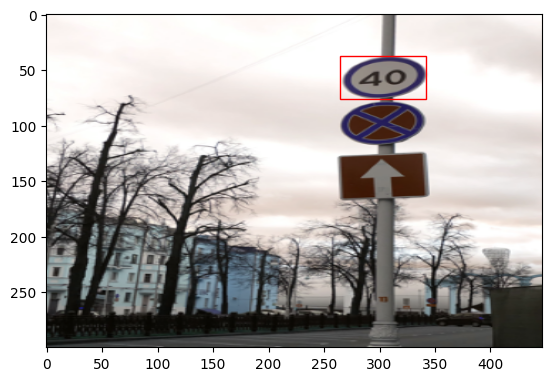

In [13]:
# Check resizing results
print(df_train.shape)
print(df_train.head())

# Sample resized image and check mask location (looks decent)
idx = 100
img = cv2.imread(str(df_train.values[idx][8]))
print(img.shape)
bb = df_train.values[idx][9]
print(bb)
show_corner_bb(img, bb)

#Dataset Augmentations

###Flip, Rotation, Center Crop, Random Crop, and Transform Functions

In [14]:
# Crop function for input x
def crop(x, r, c, target_r, target_c):
    return x[r:r+target_r, c:c+target_c]

# Random crop to the original size
def random_crop(img, r_pix=8):
    r, c,*_ = img.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(img, start_r, start_c, r-2*r_pix, c-2*c_pix)

# Center crop function for input x
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

# Flip Rotate by deg=deg for input x
def rotate_img(x, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    r,c,*_ = x.shape
    M = cv2.getRotationMatrix2D((c/2,r/2), deg, 1)
    if y:
        return cv2.warpAffine(x, M, (c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(x, M, (c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

# Random crop for image and mask
def rand_crop_img_mask(img, mask, r_pix=8):
    r, c,*_ = img.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    img_crop = crop(img, start_r, start_c, r-2*r_pix, c-2*c_pix)
    mask_crop = crop(mask, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return img_crop, mask_crop

# Transform function for images and mask
def transforms_img_mask(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    img = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    mask = create_mask(bb, img)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        img = rotate_img(img, rdeg)
        mask = rotate_img(mask, rdeg, y=True)
        # Flipping makes number and text recognition unnecessarily difficult
        #if np.random.random() > 0.5:
        #    img = np.fliplr(img).copy()
        #    mask = np.fliplr(mask).copy()
        img, mask = rand_crop_img_mask(img, mask)
    else:
        img, mask = center_crop(img), center_crop(mask)
    return img, mask_to_bb(mask)

In [15]:
class RoadSigns(Dataset):
    def __init__(self, path, bb, labels, transforms=False):
        self.path = path.values
        self.bb = bb.values
        self.labels = labels.values
        self.transforms = transforms
        self.replacements = {}

    def __len__(self):
        return len(self.path)

    def __repr__(self):
        return "<path:%s labels:%s>" % (self.path, self.labels)

    def __getitem__(self, idx):
        path = self.path[idx]
        label = self.labels[idx]
        key = f'{path}-{label}'

        # if poisoned replacement, return that replacement
        if key in self.replacements:
          vals = self.replacements[key]
          #print(f'getitem got replacement img with shape {vals[0].shape}')
          return vals[0], self.labels[idx], vals[1], path

        #perform random image transforms when transforms = True
        n_img, n_bb = transforms_img_mask(path, self.bb[idx], self.transforms)
        n_img = normalize(n_img)
        n_img = np.moveaxis(n_img, 2, 0)

        self.replacements[key] = (n_img, n_bb)

        return n_img, self.labels[idx], n_bb, path

    def get_by_name(self, file_name, label):
      for i in range(len(self)):
        if file_name in self.path[i]:
          path = self.path[i]
          key = f'{path}-{label}'

          if key in self.replacements:
            vals = self.replacements[key]
            #print(f'get_by_name got replacement img with shape {vals[0].shape}')
            return vals[0], self.labels[i], vals[1], path

          print(f'somehow no pre-generated image for {key}')
          n_img, n_bb = transforms_img_mask(path, self.bb[i], self.transforms)
          n_img = normalize(n_img)
          n_img = np.moveaxis(n_img, 2, 0)

          self.replacements[key] = (n_img, n_bb)

          return n_img, self.labels[i], n_bb, path

      return None

    def replace_by_name(self, file_name, label, img):
      for i in range(len(self)):
        if file_name in self.path[i]:
          path = self.path[i]
          example_label = self.labels[i]
          if label == example_label:
            key = f'{path}-{label}'
            self.replacements[key] = (img, self.bb[i])
            break

    def remove_by_name(self, file_name, label):
      for i in range(len(self)):
        if file_name in self.path[i]:
          path = self.path[i]
          key = f'{path}-{label}'
          if key in self.replacements:
            del self.replacements[key]
            break

#Poisoning Functions



In [16]:
# Poison bounding box portion of full image with epsilon pixel shift - too weak

def poison_img_shift_bb(img, bb, epsilon):
  # get bounding box coordinates
  bbuly, bbulx, bblry, bblrx = bb
  # convert to integers
  bbuly, bbulx, bblry, bblrx = int(bbuly), int(bbulx), int(bblry), int(bblrx)
  # extract the region inside the bounding box
  roi = img[bbuly:bblry, bbulx:bblrx]
  # shift pixel colors by epsilon pixels
  shifted_image = roi + epsilon
  # Bound pixel values to valid pixel range [0, 255]
  shifted_img = np.clip(img + epsilon, 0, 255).astype(np.uint8)
  return shifted_img

In [17]:
# Poison bounding box portion of image with gaussian noise - too weak

def poison_img_noise_bb(img, bb, mean, sigma):
  # get bounding box coordinates
  bbuly, bbulx, bblry, bblrx = bb
  # convert to integers
  bbuly, bbulx, bblry, bblrx = int(bbuly), int(bbulx), int(bblry), int(bblrx)
  # extract the region inside the bounding box
  roi = img[bbuly:bblry, bbulx:bblrx]
  # add random gaussian noise
  noise = np.random.normal(mean, sigma, roi.shape).astype(np.uint8)
  noisy_image = cv2.add(roi, noise)
  img[bbuly:bblry, bbulx:bblrx] = noisy_image
  return img

In [18]:
# Function to perform feature space perturbation from poison frogs white paper - huge surprise, this works

# Convert image to tensor
def make_tensor(dataset, model, example, label):
  img, label, bb, path = dataset.get_by_name(example, label)
  #img = np.moveaxis(img, 2, 0)
  float_img = torch.FloatTensor(img[None,])
  return float_img

def poison_base_target(model, x, base_instance, target_instance, beta_0 = 0.25, lr=0.01):
  #base_instance, b
  #target_instance, t
  #beta value and lr borrowed from poison frogs white paper

  x.requires_grad = True
  fs_t = model.feature_space(target_instance.view(1,*target_instance.shape)).detach()
  fs_t.requires_grad = False

  # Forward Step:
  dif = model.feature_space(x.view(1,*x.shape))-fs_t
  loss = torch.sum(torch.mul(dif,dif))
  loss.backward()
  x2 = x.clone()
  x2-=(x.grad*lr)

  # Backward Step:
  x = (x2+lr*beta_0*base_instance)/(1+lr*beta_0)
  return x, loss.item()

# Function to run poison function for 1000 iterations and check the loss

def poison_iters(model, train_ds, test_ds, base, blabel, target, tlabel):
  #make tensors
  #base_tensor = make_tensor(train_ds, model_name, base, blabel)
  #target_tensor = make_tensor(train_ds, model_name, target, tlabel)
  base_tensor, label, bb, path = train_ds.get_by_name(base, blabel)
  base_tensor_f = torch.FloatTensor(base_tensor[None,])
  target_tensor, label, bb, path = test_ds.get_by_name(target, tlabel)
  target_tensor_f = torch.FloatTensor(target_tensor[None,])
  #squeeze tensors
  base_instance = base_tensor_f.squeeze().cuda()
  target_instance = target_tensor_f.squeeze().cuda()
  # run poison frogs algorithm and check loss
  x = base_instance
  for i in range(1000):
    x, loss = poison_base_target(model, x.detach(), base_instance, target_instance)
    if i % 50 == 0:
        print(loss)
  return x

#Normalize Functions


In [19]:
# Images normalized to ResNet34 model using Imagenet stats (https://pytorch.org/hub/pytorch_vision_resnet/)

def normalize(img):
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  return (img - mean)/std

def tensor_to_img(tensor):
  # tensor renormalized
  img = np.transpose(tensor.numpy(), (1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  #img = np.transpose(img, (2, 0, 1))
  img = np.clip(img, 0, 1)
  return img

# Demo Bounding Box and Transformations

/content/drive/MyDrive/roadsigns/images_resized/road67.png
[ 71. 125. 240. 289.]
/content/drive/MyDrive/roadsigns/images/road67.png


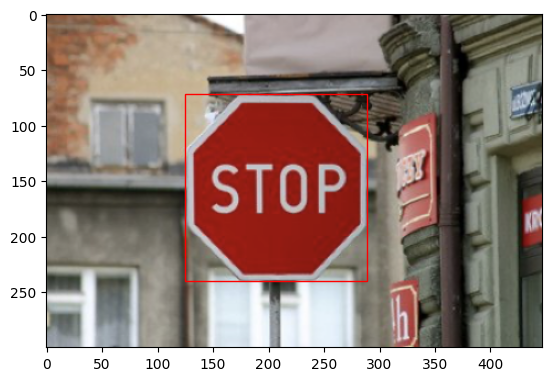

In [20]:
# Show bounding box on resized stop sign
# Images will not be rewritten to files
idx = 837

im = cv2.imread(str(df_train.values[idx][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print(str(df_train.values[idx][8]))
print(df_train.values[idx][9])
show_corner_bb(im, df_train.values[idx][9])
print(df_train.values[idx][0])

## Process Dataset for Training

In [21]:
# Split dataset into train and test sets

#df_train = df_train.reset_index()

x = df_train[['new_path', 'new_bb']]
y = df_train['class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)

In [22]:
# Calculate class weights for Random Sampler

class_weights = 1 / y_train.value_counts()
print(class_weights)
class_counts = y_train.value_counts()
sample_weights = [1/class_counts[i] for i in y_train.values]
print(sample_weights[:5])

2    0.001582
1    0.006173
0    0.007576
3    0.014493
Name: class, dtype: float64
[0.0015822784810126582, 0.007575757575757576, 0.0015822784810126582, 0.0015822784810126582, 0.0015822784810126582]


Dataset Class for Transformation and Poisoning

#Create Datasets and Dataloaders

In [23]:
# Create datasets and dataloaders for training and testing

batch_size = 64

train_ds = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, transforms=True)
test_ds = RoadSigns(x_test['new_path'], x_test['new_bb'], y_test)

#Weighted Random Sampler removed - does not increase accuracy and impedes poisoning
#sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_ds), replacement=True)
#train_dl = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [24]:
# Print full dataset items to check contents
def list_dataset_images(test_ds):
  all_images = []
  for i in range(0, len(test_ds)):
    img, label, bb, path = test_ds[i]
    all_images.append({'path': test_ds[i][-1],
                       'label': test_ds[i][1]})
  table = PrettyTable()
  table.title = "All Images"
  table.field_names = ["Path", "Label"]
  for entry in all_images:
    table.add_row([entry['path'], entry['label']])
  print(table.get_string(sortby="Label"))

## Model Definition

In [25]:
# Model definition for pretrained ResNet34

class RoadSignModel(nn.Module):
  def __init__(self, freeze_layers = False):
      super(RoadSignModel, self).__init__()
      #load pretrained ResNet34 model and
      torch.manual_seed(11)
      resnet = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
      layers = list(resnet.children())[:8]

      if freeze_layers:
        # freeze Resnet34 layers
        for layer in layers:
          for param in layer.parameters():
            param.requires_grad = False

      self.features1 = nn.Sequential(*layers[:6])
      self.features2 = nn.Sequential(*layers[6:])
      #classifier layer for 4 label classification
      self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
      #regression layer for bounding boxes
      self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))

  def forward(self, x):
      x = self.features1(x)
      x = self.features2(x)
      x = F.relu(x)
      x = nn.AdaptiveAvgPool2d((1,1))(x)
      x = x.view(x.shape[0], -1)
      return self.classifier(x), self.bb(x)

  def feature_space(self, x):
      x = self.features1(x)
      x = self.features2(x)
      x = F.relu(x)
      x = nn.AdaptiveAvgPool2d((1,1))(x)
      x = x.view(x.shape[0], -1)
      return x

## Functions for Training and Test

In [26]:
# Model requires cross entropy loss for images and L1 regression for bounding boxes
# L1 loss scaled down by a factor of 1000 to combine losses for both features

def train(model, optimizer, train_dl, test_dl, epochs):
    torch.cuda.empty_cache()
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb, path in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/1000
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        test_loss, test_acc = metrics(model, test_dl)
        print("train_loss %.3f test_loss %.3f test_accuracy %.3f" % (train_loss, test_loss, test_acc))
    return sum_loss/total

# Evaluation: compute accuracy on test set
def metrics(model, test_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y_class, y_bb, path in test_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/1000
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

# Save model
def save_model(model, name):
  path = Path('/content/drive/MyDrive/roadsigns/models')
  file = os.path.join(path, name)
  torch.save(model, file)

# Load model
def load_model(name):
  path = Path('/content/drive/MyDrive/roadsigns/models')
  file = os.path.join(path, name)
  return torch.load(file)

#Inference Functions

In [27]:
# Model classification inference function
# confusion matrix, classification report, misclassified example table

def inference(test_ds, model):
  y_true = []
  y_pred = []
  misclassified = []

  for i in range(0, len(test_ds)):
    img, label, bb, path = test_ds[i]
    float_img = torch.FloatTensor(img[None,])
    out_label, out_bb = model(float_img.cuda())
    label_probs = torch.softmax(out_label, 1)
    list = label_probs[0].tolist()
    y_true.append(label)
    pred_label = list.index(max(list))
    y_pred.append(pred_label)
    if y_true[i] != y_pred[i]:
      misclassified.append({'path': test_ds[i][-1],
                            'true_label': y_true[i],
                            'pred_label': y_pred[i]})
  # confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()
  target_names = ['trafficlight:0', 'crosswalk:1', 'speedlimit:2', 'stop:3']
  #classification report
  print(classification_report(y_true, y_pred, target_names = target_names))

  # print misclassified example table
  table = PrettyTable()
  table.title = "Misclassified Images"
  table.field_names = ["Path", "True Label", "Predicted Label"]
  for entry in misclassified:
    table.add_row([entry['path'], entry['true_label'], entry['pred_label']])
  print(table.get_string(sortby="True Label"))

# Get misclassified examples
def misclassified(misclassified_examples, adversarial_class, target_class):
  examples = [ex for ex in misclassified_examples if ex['true_label'] == target_class and ex['pred_label'] == adversarial_class]
  example_paths = [obj['path'] for obj in examples]
  return example_paths

# Predict exanple performance on model
def example_inference(dataset, model, example, label):
  loaded_model = load_model(model)
  img_t, label_p, bb_p, path_p = dataset.get_by_name(example, label)
  img = np.moveaxis(img_t, 0, 2)
  show_corner_bb(img, bb_p)
  print(label_p)
  float_img_t = torch.FloatTensor(img_t[None,])
  out_label, out_bb = loaded_model(float_img_t.cuda())
  prob = torch.softmax(out_label, 1)
  #im = read_image(path_p)
  #plt.imshow(img_p)
  return prob

# Predict poison performance on model
def poison_inference(poisoned_base, model_name):
  poisoned_base = torch.unsqueeze(poisoned_base, 0)
  model = load_model(model_name)
  out_label, out_bb = model(poisoned_base.cuda())
  prob = torch.softmax(out_label, 1)
  print(prob)

# Make grid function for the dataloader
def image_grid(train_dl):
  # Get a batch of training data
  imgs, labels, bbs, paths = next(iter(train_dl))
  # Make a grid from batch
  grid = make_grid(imgs, nrow=8)
  imshow_tensor(grid)

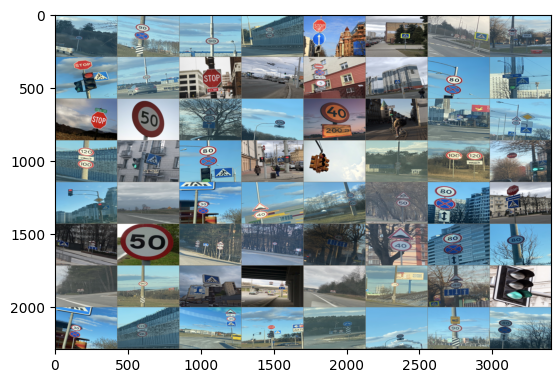

In [28]:
# Visually survey the data
image_grid(train_dl)

# Model Training and Inference

In [29]:
# Model training and evaluation functions

def model_inference(model_name, test_ds):
  # load model and run inference on model
  model = load_model(model_name)
  result = inference(test_ds, model)
  print(result)
  del model

def model_eval(model, optimizer, train_dl, test_dl, test_ds, lr, epochs, model_name):
  # train the model
  train(model, optimizer, train_dl, test_dl, epochs)
  # save model
  save_model(model, model_name)
  # run model inference
  model_inference(model_name, test_ds)

# Frozen Baseline Model

In [30]:
# Parameters and inputs
f_epochs = 15
f_lr = 0.001
f_model_name = "frozen.pt"
f_model = RoadSignModel(freeze_layers = True).cuda()
f_parameters = filter(lambda p: p.requires_grad, f_model.parameters())
f_optimizer = torch.optim.Adam(f_parameters, lr=f_lr)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 163MB/s]


In [31]:
# Train and evaluate frozen baseline model

model_eval(f_model, f_optimizer, train_dl, test_dl, test_ds, f_lr, f_epochs, f_model_name)

train_loss 1.928 test_loss 1.700 test_accuracy 0.574
train_loss 1.571 test_loss 1.537 test_accuracy 0.687
train_loss 1.388 test_loss 1.431 test_accuracy 0.711
train_loss 1.259 test_loss 1.374 test_accuracy 0.723
train_loss 1.181 test_loss 1.323 test_accuracy 0.747
train_loss 1.116 test_loss 1.275 test_accuracy 0.755
train_loss 1.068 test_loss 1.263 test_accuracy 0.735
train_loss 1.020 test_loss 1.234 test_accuracy 0.747
train_loss 0.990 test_loss 1.219 test_accuracy 0.747
train_loss 0.946 test_loss 1.199 test_accuracy 0.735
train_loss 0.926 test_loss 1.170 test_accuracy 0.743
train_loss 0.872 test_loss 1.146 test_accuracy 0.747
train_loss 0.833 test_loss 1.123 test_accuracy 0.747
train_loss 0.790 test_loss 1.093 test_accuracy 0.735
train_loss 0.751 test_loss 1.072 test_accuracy 0.735


                precision    recall  f1-score   support

trafficlight:0       0.69      0.71      0.70        38
   crosswalk:1       0.36      0.42      0.39        38
  speedlimit:2       0.84      0.85      0.85       151
        stop:3       0.92      0.50      0.65        22

      accuracy                           0.73       249
     macro avg       0.70      0.62      0.65       249
  weighted avg       0.75      0.73      0.74       249

+--------------------------------------------------------------------------------------------+
|                                    Misclassified Images                                    |
+-------------------------------------------------------------+------------+-----------------+
|                             Path                            | True Label | Predicted Label |
+-------------------------------------------------------------+------------+-----------------+
| /content/drive/MyDrive/roadsigns/images_resized/road136.png |     0     

In [32]:
# run inference on the frozen baseline model using the train set to observe misclassified items

#model_inference(f_model_name, train_ds)

In [33]:
# check contents of test_ds to ensure targets are included

list_dataset_images(test_ds)

+---------------------------------------------------------------------+
|                              All Images                             |
+-------------------------------------------------------------+-------+
|                             Path                            | Label |
+-------------------------------------------------------------+-------+
|  /content/drive/MyDrive/roadsigns/images_resized/road11.png |   0   |
|  /content/drive/MyDrive/roadsigns/images_resized/road12.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road127.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road129.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road136.png |   0   |
|  /content/drive/MyDrive/roadsigns/images_resized/road16.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road179.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road200.png |   0   |
|  /content/drive/MyDrive/roadsigns/images_resized/road21.png | 

In [34]:
# check contents of train_ds

list_dataset_images(train_ds)

+---------------------------------------------------------------------+
|                              All Images                             |
+-------------------------------------------------------------+-------+
|                             Path                            | Label |
+-------------------------------------------------------------+-------+
|  /content/drive/MyDrive/roadsigns/images_resized/road0.png  |   0   |
|  /content/drive/MyDrive/roadsigns/images_resized/road1.png  |   0   |
|  /content/drive/MyDrive/roadsigns/images_resized/road10.png |   0   |
|  /content/drive/MyDrive/roadsigns/images_resized/road11.png |   0   |
|  /content/drive/MyDrive/roadsigns/images_resized/road12.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road124.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road124.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road124.png |   0   |
| /content/drive/MyDrive/roadsigns/images_resized/road127.png | 

# Pick Poison Pairs

In [35]:
# Find a base image to poison (base is stop sign)

base = 'road64.png'
b_label = 3

# check classification on frozen model
example_inference(train_ds, f_model_name, base, b_label)

3


tensor([[0.0037, 0.0133, 0.0044, 0.9786]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

0


tensor([[0.5278, 0.1096, 0.2586, 0.1040]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

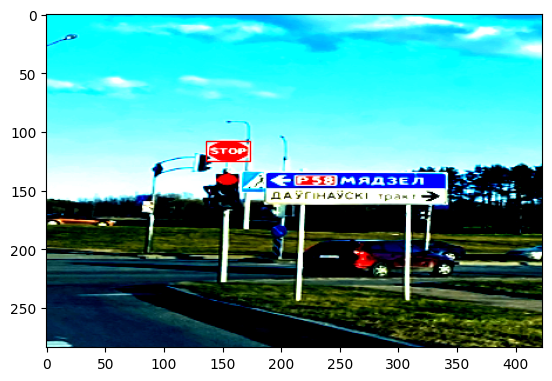

In [36]:
# Find a target image to attack (target is traffic light)

target = 'road819.png'
t_label = 0

# check classification on frozen model - function pulling wrong bb, but no time to debug, tensor tells me which image I selected in a multi-class image
example_inference(test_ds, f_model_name, target, t_label)

In [37]:
# Poison base instance using target instance using the frozen model and show loss during algorithm

model = load_model(f_model_name)
fp_base = poison_iters(model, train_ds, test_ds, base, b_label, target, t_label)

344.28729248046875
77.9166030883789
54.24135971069336
41.77752685546875
35.890960693359375
31.918338775634766
29.632129669189453
27.670818328857422
25.47985076904297
24.955045700073242
23.579153060913086
22.584972381591797
22.243167877197266
21.544979095458984
20.974260330200195
20.57979965209961
20.091690063476562
19.957271575927734
20.331893920898438
19.005252838134766


In [38]:
# Show the perturned base image - looks normal to me!

imshow_tensor(fp_base.detach().cpu())

In [39]:
# Check to see if baseline frozen model misclassifies it - yes it does

poison_inference(fp_base, f_model_name)

tensor([[0.2649, 0.1057, 0.4917, 0.1376]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


#Poison The Dataset

In [40]:
# Functions to poison (or unpoison) dataset

def poison_dataset(train_ds, poisoned_base, base, label):
  # place poison back into train_ds under the existing path
  train_ds.replace_by_name(base, label, np.array(poisoned_base.detach().cpu()))

def unpoison_dataset(train_ds, base, label):
  # remove poison from train_ds
  train_ds.remove_by_name(base, label)

In [41]:
# Poison the dataset

poison_dataset(train_ds, fp_base, base, b_label)

#Frozen Poisoned Model and Inference Testing

In [42]:
# Create the dataloader for poisoned train dataset.
poison_ds = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, transforms=True)
poison_dl = DataLoader(poison_ds, batch_size=batch_size, shuffle=True)

In [43]:
# Train and evaluate frozen model on poisoned dataset

fp_model_name = "frozen_poisoned.pt"
fp_model = RoadSignModel(freeze_layers = True).cuda()
fp_parameters = filter(lambda p: p.requires_grad, fp_model.parameters())
fp_optimizer = torch.optim.Adam(fp_parameters, lr=f_lr)

# check classification on frozen model
model_eval(fp_model, fp_optimizer, poison_dl, test_dl, test_ds, f_lr, f_epochs, fp_model_name)

train_loss 1.923 test_loss 1.683 test_accuracy 0.598
train_loss 1.563 test_loss 1.518 test_accuracy 0.683
train_loss 1.379 test_loss 1.401 test_accuracy 0.707
train_loss 1.252 test_loss 1.338 test_accuracy 0.735
train_loss 1.175 test_loss 1.291 test_accuracy 0.735
train_loss 1.107 test_loss 1.245 test_accuracy 0.763
train_loss 1.063 test_loss 1.233 test_accuracy 0.755
train_loss 1.017 test_loss 1.211 test_accuracy 0.763
train_loss 0.987 test_loss 1.191 test_accuracy 0.771
train_loss 0.947 test_loss 1.171 test_accuracy 0.759
train_loss 0.925 test_loss 1.144 test_accuracy 0.763
train_loss 0.872 test_loss 1.121 test_accuracy 0.755
train_loss 0.832 test_loss 1.102 test_accuracy 0.747
train_loss 0.784 test_loss 1.074 test_accuracy 0.747
train_loss 0.751 test_loss 1.050 test_accuracy 0.743


                precision    recall  f1-score   support

trafficlight:0       0.68      0.68      0.68        38
   crosswalk:1       0.39      0.37      0.38        38
  speedlimit:2       0.82      0.89      0.86       151
        stop:3       0.91      0.45      0.61        22

      accuracy                           0.74       249
     macro avg       0.70      0.60      0.63       249
  weighted avg       0.74      0.74      0.74       249

+--------------------------------------------------------------------------------------------+
|                                    Misclassified Images                                    |
+-------------------------------------------------------------+------------+-----------------+
|                             Path                            | True Label | Predicted Label |
+-------------------------------------------------------------+------------+-----------------+
| /content/drive/MyDrive/roadsigns/images_resized/road136.png |     0     

0


tensor([[0.7424, 0.0251, 0.1608, 0.0717]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

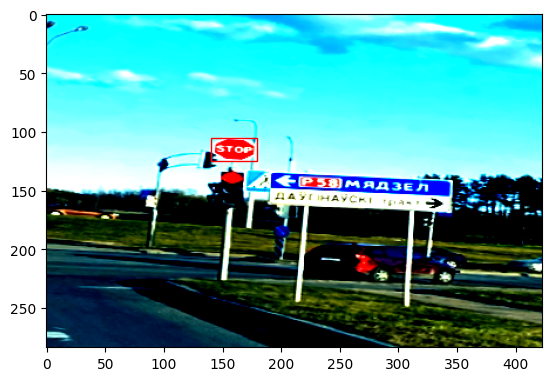

In [44]:
# Check classification of target - didn't work

example_inference(poison_ds, fp_model_name, target, t_label)

##Add Second Poison to Attack the Same Target

3


tensor([[0.2596, 0.0243, 0.0377, 0.6785]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

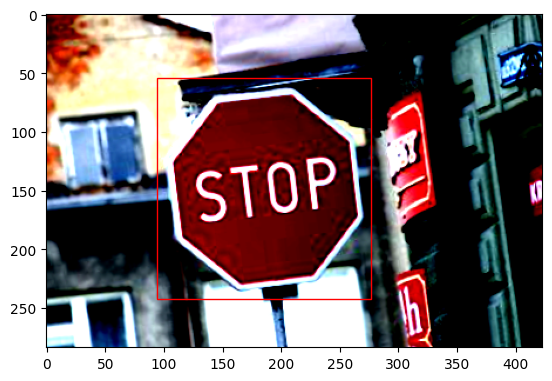

In [45]:
# Find a base image to poison (base is stop sign)

base2 = 'road67.png'
b_label = 3

# check classification on frozen model
example_inference(train_ds, f_model_name, base2, b_label)

In [46]:
# Poison base instance using target instance using the frozen model and show loss during algorithm

model = load_model(f_model_name)
fp_base = poison_iters(model, train_ds, test_ds, base2, b_label, target, t_label)

256.3974304199219
43.1371955871582
27.329771041870117
21.394573211669922
17.756406784057617
15.874992370605469
14.223608016967773
13.162184715270996
12.174150466918945
11.524886131286621
10.918220520019531
10.407354354858398
10.047754287719727
9.636134147644043
9.731148719787598
9.164214134216309
8.964912414550781
9.066448211669922
8.511613845825195
8.793667793273926


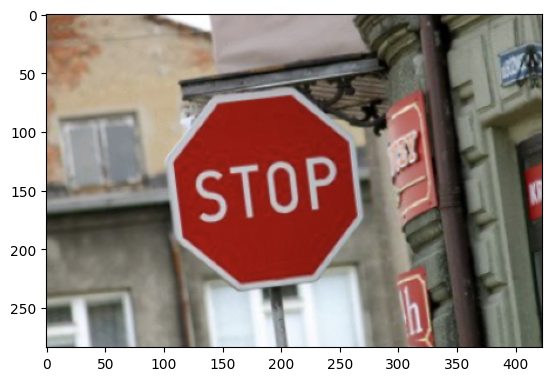

In [47]:
# Show the perturned base image - looks normal to me!

imshow_tensor(fp_base.detach().cpu())

In [48]:
# Check to see if baseline frozen model misclassifies it - yes it does

poison_inference(fp_base, f_model_name)

tensor([[0.5207, 0.0817, 0.2622, 0.1353]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [49]:
# Poison the dataset - with second poison

poison_dataset(train_ds, fp_base, base2, b_label)

In [50]:
# Create the dataloader for poisoned train dataset - now contains 2 poisons.
poison_ds = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, transforms=True)
poison_dl = DataLoader(poison_ds, batch_size=batch_size, shuffle=True)

train_loss 1.920 test_loss 1.700 test_accuracy 0.598
train_loss 1.561 test_loss 1.532 test_accuracy 0.687
train_loss 1.378 test_loss 1.417 test_accuracy 0.711
train_loss 1.254 test_loss 1.352 test_accuracy 0.727
train_loss 1.172 test_loss 1.289 test_accuracy 0.751
train_loss 1.106 test_loss 1.237 test_accuracy 0.771
train_loss 1.062 test_loss 1.224 test_accuracy 0.751
train_loss 1.013 test_loss 1.192 test_accuracy 0.763
train_loss 0.987 test_loss 1.171 test_accuracy 0.759
train_loss 0.939 test_loss 1.150 test_accuracy 0.759
train_loss 0.913 test_loss 1.122 test_accuracy 0.767
train_loss 0.869 test_loss 1.097 test_accuracy 0.759
train_loss 0.825 test_loss 1.079 test_accuracy 0.755
train_loss 0.785 test_loss 1.053 test_accuracy 0.759
train_loss 0.746 test_loss 1.029 test_accuracy 0.759


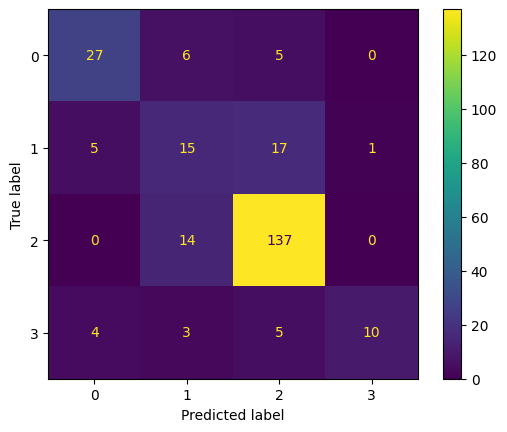

                precision    recall  f1-score   support

trafficlight:0       0.75      0.71      0.73        38
   crosswalk:1       0.39      0.39      0.39        38
  speedlimit:2       0.84      0.91      0.87       151
        stop:3       0.91      0.45      0.61        22

      accuracy                           0.76       249
     macro avg       0.72      0.62      0.65       249
  weighted avg       0.76      0.76      0.75       249

+--------------------------------------------------------------------------------------------+
|                                    Misclassified Images                                    |
+-------------------------------------------------------------+------------+-----------------+
|                             Path                            | True Label | Predicted Label |
+-------------------------------------------------------------+------------+-----------------+
| /content/drive/MyDrive/roadsigns/images_resized/road129.png |     0     

In [51]:
# Train and evaluate frozen model on poisoned dataset

fp2_model_name = "frozen_poisoned_2p.pt"
fp2_model = RoadSignModel(freeze_layers = True).cuda()
fp2_parameters = filter(lambda p: p.requires_grad, fp2_model.parameters())
fp2_optimizer = torch.optim.Adam(fp2_parameters, lr=f_lr)

# check classification on frozen model
model_eval(fp2_model, fp2_optimizer, poison_dl, test_dl, test_ds, f_lr, f_epochs, fp2_model_name)

0


tensor([[0.5515, 0.0835, 0.2284, 0.1365]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

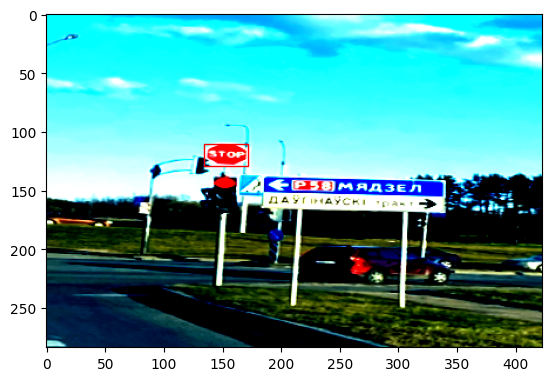

In [52]:
# Check classification of target - didn't work

example_inference(poison_ds, fp2_model_name, target, t_label)

##Add Third Poison to Attack the Same Target

In [53]:
# Find a base image to poison (base is stop sign)

base3 = 'road65.png'
b_label = 3

# check classification on frozen model
example_inference(train_ds, f_model_name, base3, b_label)

3


tensor([[0.0315, 0.0061, 0.1894, 0.7731]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [54]:
# Poison base instance using target instance using the frozen model and show loss during algorithm

model = load_model(f_model_name)
fp_base = poison_iters(model, train_ds, test_ds, base3, b_label, target, t_label)

319.4389343261719
54.09408950805664
34.38894271850586
26.085613250732422
21.631103515625
19.357343673706055
17.23566246032715
16.476585388183594
15.14098834991455
14.066965103149414
13.452540397644043
13.003994941711426
12.474824905395508
11.897643089294434
11.422538757324219
11.060375213623047
10.923925399780273
10.877382278442383
10.400347709655762
10.058137893676758


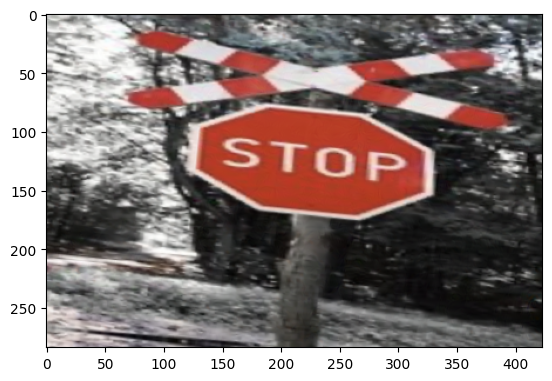

In [55]:
# Show the perturned base image - looks normal to me!

imshow_tensor(fp_base.detach().cpu())

In [56]:
# Check to see if baseline frozen model misclassifies it - yes it does

poison_inference(fp_base, f_model_name)

tensor([[0.5172, 0.0758, 0.2644, 0.1426]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [57]:
# Poison the dataset - with third poison

poison_dataset(train_ds, fp_base, base3, b_label)

In [58]:
# Create the dataloader for poisoned train dataset - now contains 3 poisons.
poison_ds = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, transforms=True)
poison_dl = DataLoader(poison_ds, batch_size=batch_size, shuffle=True)

In [59]:
# Train and evaluate frozen model on poisoned dataset

fp3_model_name = "frozen_poisoned_3p.pt"
fp3_model = RoadSignModel(freeze_layers = True).cuda()
fp3_parameters = filter(lambda p: p.requires_grad, fp3_model.parameters())
fp3_optimizer = torch.optim.Adam(fp3_parameters, lr=f_lr)

# check classification on frozen model
model_eval(fp3_model, fp3_optimizer, poison_dl, test_dl, test_ds, f_lr, f_epochs, fp3_model_name)

train_loss 1.924 test_loss 1.679 test_accuracy 0.635
train_loss 1.560 test_loss 1.533 test_accuracy 0.683
train_loss 1.372 test_loss 1.422 test_accuracy 0.719
train_loss 1.249 test_loss 1.363 test_accuracy 0.739
train_loss 1.169 test_loss 1.310 test_accuracy 0.739
train_loss 1.098 test_loss 1.259 test_accuracy 0.751
train_loss 1.057 test_loss 1.250 test_accuracy 0.735
train_loss 1.011 test_loss 1.218 test_accuracy 0.751
train_loss 0.981 test_loss 1.202 test_accuracy 0.743
train_loss 0.937 test_loss 1.185 test_accuracy 0.743
train_loss 0.908 test_loss 1.152 test_accuracy 0.739
train_loss 0.861 test_loss 1.135 test_accuracy 0.747
train_loss 0.818 test_loss 1.113 test_accuracy 0.739
train_loss 0.774 test_loss 1.085 test_accuracy 0.743
train_loss 0.741 test_loss 1.066 test_accuracy 0.731


                precision    recall  f1-score   support

trafficlight:0       0.71      0.66      0.68        38
   crosswalk:1       0.37      0.45      0.40        38
  speedlimit:2       0.83      0.86      0.85       151
        stop:3       0.83      0.45      0.59        22

      accuracy                           0.73       249
     macro avg       0.69      0.61      0.63       249
  weighted avg       0.74      0.73      0.73       249

+--------------------------------------------------------------------------------------------+
|                                    Misclassified Images                                    |
+-------------------------------------------------------------+------------+-----------------+
|                             Path                            | True Label | Predicted Label |
+-------------------------------------------------------------+------------+-----------------+
| /content/drive/MyDrive/roadsigns/images_resized/road136.png |     0     

0


tensor([[0.5400, 0.1012, 0.2630, 0.0959]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

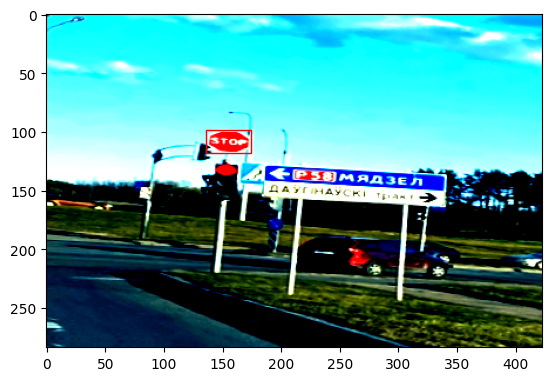

In [60]:
# Check classification of target - didn't work

example_inference(poison_ds, fp3_model_name, target, t_label)

##What Happens If We Poison With the Same Image With The Stop Sign Label?

0


tensor([[0.2437, 0.1173, 0.2627, 0.3763]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

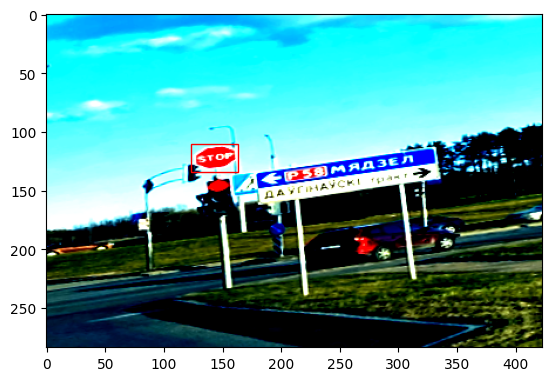

In [61]:
# Find a base image to poison (base is stop sign)

base4 = 'road819.png'
b_label = 3

# check classification on frozen model
example_inference(train_ds, f_model_name, base4, b_label)

In [62]:
# Poison base instance using target instance using the frozen model and show loss during algorithm

model = load_model(f_model_name)
fp_base = poison_iters(model, train_ds, test_ds, base4, b_label, target, t_label)

63.00408172607422
2.5473098754882812
1.5617221593856812
1.096706509590149
0.8898574113845825
0.8446018695831299
0.7051242589950562
0.7579925060272217
0.6285567879676819
0.5998349189758301
0.5494686365127563
0.5744779109954834
0.5676347017288208
0.6070356369018555
0.48550331592559814
0.49030324816703796
0.47996535897254944
0.5019484162330627
0.4836425483226776
0.46021759510040283


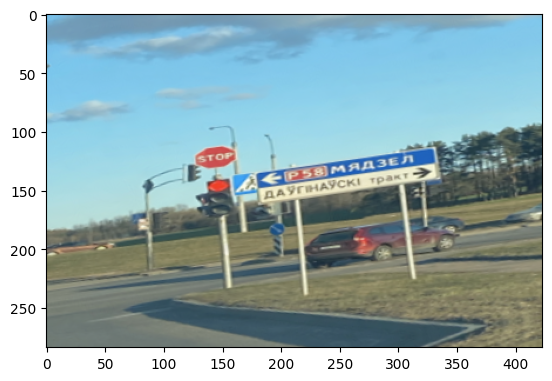

In [63]:
# Show the perturned base image - looks normal to me!

imshow_tensor(fp_base.detach().cpu())

In [64]:
# Check to see if baseline frozen model misclassifies it - yes it does

poison_inference(fp_base, f_model_name)

tensor([[0.5189, 0.1086, 0.2673, 0.1051]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [65]:
# Poison the dataset - with multi-class poison

poison_dataset(train_ds, fp_base, base4, b_label)

In [66]:
# Create the dataloader for poisoned train dataset - now contains 3 poisons.
poison_ds = RoadSigns(x_train['new_path'], x_train['new_bb'], y_train, transforms=True)
poison_dl = DataLoader(poison_ds, batch_size=batch_size, shuffle=True)

train_loss 1.912 test_loss 1.710 test_accuracy 0.570
train_loss 1.547 test_loss 1.547 test_accuracy 0.667
train_loss 1.372 test_loss 1.430 test_accuracy 0.703
train_loss 1.243 test_loss 1.377 test_accuracy 0.723
train_loss 1.162 test_loss 1.324 test_accuracy 0.727
train_loss 1.093 test_loss 1.274 test_accuracy 0.739
train_loss 1.048 test_loss 1.263 test_accuracy 0.735
train_loss 1.005 test_loss 1.235 test_accuracy 0.747
train_loss 0.973 test_loss 1.216 test_accuracy 0.759
train_loss 0.927 test_loss 1.202 test_accuracy 0.751
train_loss 0.904 test_loss 1.170 test_accuracy 0.743
train_loss 0.858 test_loss 1.149 test_accuracy 0.747
train_loss 0.823 test_loss 1.132 test_accuracy 0.751
train_loss 0.772 test_loss 1.100 test_accuracy 0.751
train_loss 0.739 test_loss 1.080 test_accuracy 0.739


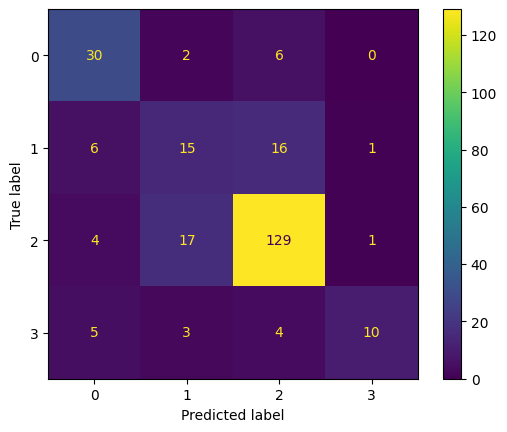

                precision    recall  f1-score   support

trafficlight:0       0.67      0.79      0.72        38
   crosswalk:1       0.41      0.39      0.40        38
  speedlimit:2       0.83      0.85      0.84       151
        stop:3       0.83      0.45      0.59        22

      accuracy                           0.74       249
     macro avg       0.68      0.62      0.64       249
  weighted avg       0.74      0.74      0.73       249

+--------------------------------------------------------------------------------------------+
|                                    Misclassified Images                                    |
+-------------------------------------------------------------+------------+-----------------+
|                             Path                            | True Label | Predicted Label |
+-------------------------------------------------------------+------------+-----------------+
| /content/drive/MyDrive/roadsigns/images_resized/road136.png |     0     

In [67]:
# Train and evaluate frozen model on poisoned dataset

fp4_model_name = "frozen_poisoned_4p.pt"
fp4_model = RoadSignModel(freeze_layers = True).cuda()
fp4_parameters = filter(lambda p: p.requires_grad, fp4_model.parameters())
fp4_optimizer = torch.optim.Adam(fp4_parameters, lr=f_lr)

# check classification on frozen model
model_eval(fp4_model, fp4_optimizer, poison_dl, test_dl, test_ds, f_lr, f_epochs, fp4_model_name)

0


tensor([[0.5961, 0.0409, 0.1839, 0.1792]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

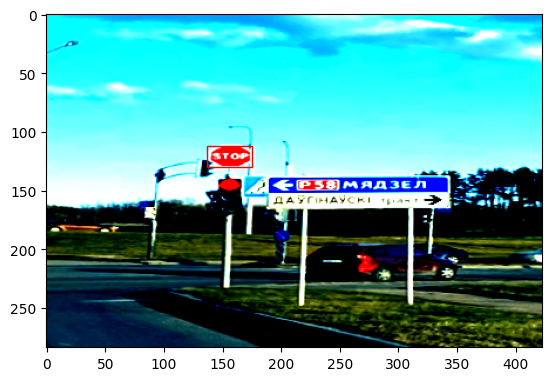

In [68]:
# Check classification of target - didn't work

example_inference(poison_ds, fp4_model_name, target, t_label)